In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os


def phases(iq: np.ndarray,start:int):
    list = []
    for i in range(start,len(iq)-2,6):
        list.append(
            np.angle(complex(iq[i],iq[i+1]))
        )
    return np.array(list)


def single_antenna_to_dataframe(read_fp: str, write_fp=None) -> pd.DataFrame:
    '''Transforma uma captura com uma única antena em um df '''
    raw =pd.read_json(read_fp)
    df= list()
    for group in raw[1]:
        group["Angle"] = read_fp.split('_')[1].split("-")[0]
        group["Distance"] = read_fp.split('_')[-1].split("-")[-1].split(".")[0]
        df.append(group)
    df = pd.DataFrame(df)
    df = df.join(pd.DataFrame(df["aoa"].to_list()))
    df.pop("aoa")

    if write_fp is not None:
        df.to_json(write_fp)
    else:
        return df

data = pd.DataFrame()

for fp in os.listdir("./data"):
    df = single_antenna_to_dataframe("./data/" + fp)
    data = pd.concat( (df, data))

data =data.reset_index()

In [37]:
data.to_json("./data.json")

In [38]:
data

,index,mac,timestamp,no,rssi,raw,Angle,Distance,frequency,iq
0,0,c300000a7a63,2024-10-04T15:45:53.217Z,0,-52,0201061bff3906cafb0114fff9ffe200fd000000000000...,90,200,2426,"[97, -130, 107, 121, -138, 80, -51, -154, 165,..."
1,1,c300000a7a63,2024-10-04T15:45:53.740Z,0,-55,0201061bff3906cafb0114f9ffe2fffd00000000000000...,90,200,2480,"[-155, -73, 94, -150, 115, 121, -139, 98, -52,..."
2,2,c300000a7a63,2024-10-04T15:45:54.273Z,0,-58,0201061bff3906cafb0114f9ffe4ff0001000000000000...,90,200,2480,"[-83, -157, 169, -58, 14, 170, -177, -24, 51, ..."
3,3,c300000a7a63,2024-10-04T15:45:54.786Z,0,-53,0201061bff3906cafb0114f9ffe7ff0001000000000000...,90,200,2402,"[-147, -58, 92, -131, 101, 121, -143, 71, -48,..."
4,4,c300000a7a63,2024-10-04T15:45:55.320Z,0,-53,0201061bff3906cafb0114f9ffe4ff0001000000000000...,90,200,2402,"[-88, -144, 141, -55, 4, 155, -159, -19, 36, -..."
...,...,...,...,...,...,...,...,...,...,...
8609,228,c300000a7a48,2024-10-04T17:05:24.358Z,0,-56,0201061bff3906cafb01140000ecff0001000000000000...,0,100,2402,"[-47, 171, -145, -56, 99, -123, 115, 139, -143..."
8610,229,c300000a7a48,2024-10-04T17:05:24.882Z,0,-56,0201061bff3906cafb0114feffecfffd00000000000000...,0,100,2402,"[148, 65, -99, 127, -114, -122, 139, -90, 67, ..."
8611,230,c300000a7a48,2024-10-04T17:05:25.667Z,0,-56,0201061bff3906cafb01140000ffe90102000000000000...,0,100,2426,"[-142, -72, 101, -125, 115, 114, -127, 90, -59..."
8612,231,c300000a7a48,2024-10-04T17:05:25.928Z,0,-57,0201061bff3906cafb01140000e9ff0201000000000000...,0,100,2426,"[-157, -15, 40, -160, 153, 55, -74, 145, -120,..."


In [1]:
tdata = []
tlabels = []

for _, row in data.iterrows():
    for i in range(16,len(row["iq"])-6,3*2):
        tdata.append("frequency",row["iq"][i:i+6])
        tlabels.append(row["Angle"])
len(tdata) == len(tlabels)

NameError: name 'data' is not defined

In [41]:
len(tdata)

94754

In [46]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error

#Loading the Iris dataset

label_mapper = lambda x: {"0":0,
                "15":1,
                "30":2,
                "45":3,
                "60":4,
                "75":5,
                "90":6,
                "105":7,
                "120":8,
                "135":9,
                "150":10,
                "165":11,
                "180":12,
                }.get(str(x))

X, y = tdata, [label_mapper(x) for x in tlabels]

#Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#Creating an XGBoost classifier
model = xgb.XGBClassifier(enable_categorical=True)

#Training the model on the training data
model.fit(X_train, y_train)


ValueError: setting an array element with a sequence.

In [ ]:
model.save_model(fname="./classifier.json")


In [27]:
#Making predictions on the test set
predictions = model.predict(X_test)

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names={"0","15","30","45","60","75","90","105","120","135","150","165","180"}))

Accuracy: 0.9610229711190066

Classification Report:
              precision    recall  f1-score   support

          45       0.96      0.94      0.95      2283
         105       0.93      0.92      0.92      2240
         120       0.92      0.93      0.93      2227
          75       0.97      0.98      0.97      1981
         150       0.98      0.98      0.98      2009
          30       0.98      0.96      0.97      1940
         165       0.95      0.97      0.96      2027
         135       0.97      0.95      0.96      2311
          15       0.96      0.98      0.97      2278
           0       0.98      0.98      0.98      2350
          60       0.97      0.97      0.97      2132
         180       0.96      0.95      0.96      2377
          90       0.98      0.98      0.98      2272

    accuracy                           0.96     28427
   macro avg       0.96      0.96      0.96     28427
weighted avg       0.96      0.96      0.96     28427



# Regressor

In [27]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error

#Loading the Iris dataset

X, y = np.array(tdata), [int(x) for x in tlabels]

#Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#Creating an XGBoost classifier
model = xgb.XGBRegressor(eval_metric=mean_absolute_error)

#Training the model on the training data
model.fit(X_train, y_train)
model.save_model(fname="./regressor.json")

In [8]:
#Making predictions on the test set
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print('Erro Médio Absoluto:', mae)

# Calcular MSE
mse = mean_squared_error(y_test, predictions)
print('Erro Quadrático Médio:', mse)

# Calcular RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print('Raiz do Erro Quadrático Médio:', rmse)

Erro Médio Absoluto: 7.049002482738389
Erro Quadrático Médio: 116.80522319169552
Raiz do Erro Quadrático Médio: 10.807646514930784


In [12]:
i=np.random.randint(len(X_test))
predictions = model.predict([X_test[i]])
print(f"{predictions=} \n answer={y_test[i]}")


predictions=array([5.2073607], dtype=float32) 
 answer=15


In [18]:
predictions = []

for i in range(len(X_test)):
    predictions.append(model.predict([X_test[i]]))

In [23]:
diff =np.array(y_test)-np.array(predictions)

MemoryError: Unable to allocate 222. KiB for an array with shape (28427,) and data type float64

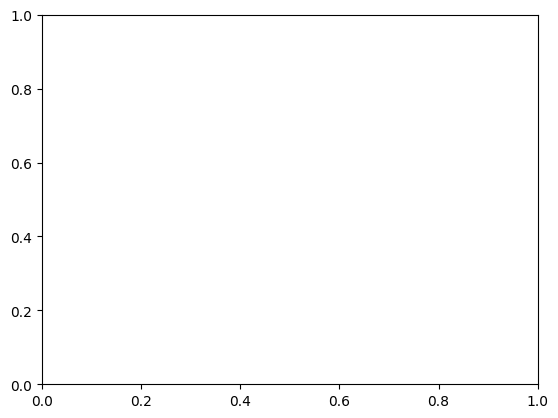

In [24]:
from matplotlib import pyplot as plt

plt.plot(y_test,diff,".")

array([5.2073607], dtype=float32)